In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load data

In [2]:
reviews = pd.read_csv('reviews_en_polarity.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,en,0.9626
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,en,0.9061
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,en,0.9663
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,en,0.9267
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just mins walk from the Airp...,en,0.8658


In [3]:
df_rec = reviews[['reviewer_id', 'listing_id', 'polarity']]

In [5]:
df_rec.nunique()

reviewer_id    59623
listing_id      2756
polarity        4631
dtype: int64

In [8]:
df_rec

,reviewer_id,listing_id,polarity
0,4298113,1178162,0.9626
1,6452964,1178162,0.9061
2,6449554,1178162,0.9663
3,2215611,1178162,0.9267
4,6848427,1178162,0.8658
...,...,...,...
63738,66618882,7462268,0.8955
63739,40052513,7462268,0.9504
63740,77129134,7462268,0.9693
63741,15799803,7462268,0.9957


# Build recommendation engine

In [4]:
# create utility matrix

matrix = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
matrix.head()

listing_id,3353,5506,6695,6976,8792,9273,9765,9824,9855,9857,...,14770708,14770892,14774426,14774868,14778561,14780153,14813006,14823724,14843050,14843783
reviewer_id,,,,,,,,,,,,,,,,,,,,,
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# keep track of reviewers (users) and listings (items)

userrows = list(matrix.index)
users_index = {userrows[i]: i for i in range(len(userrows))}

itemcols = list(matrix.columns)
items_index = {itemcols[i]: i for i in range(len(itemcols))}

## Option 1: use SVD

In [11]:
from scipy.sparse.linalg import svds

# this function also incorporates creating the utility matrix and keep track of reviewer and listing IDs

def recommend_predictions(df_rec, k):
    """
    :param df_rec: dataframe with polarity values for known reviewer/listing pairs
    :param k: number of features to keep for SVD

    returns the dataframe with predicted polarity values for all (user,item) pairs
    """
    # get utility matrix
    util_mat = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')

    # keep track of reviewers and listings
    reviewer_rows = list(util_mat.index)
    reviewer_index = {reviewer_rows[i]: i for i in range(len(reviewer_rows))}
    listing_cols = list(util_mat.columns)
    listing_index = {listing_cols[i]: i for i in range(len(listing_cols))}

    # mask NaN and remove means
    mask = np.isnan(util_mat)
    masked_arr = np.ma.masked_array(util_mat, mask)
    item_means = np.mean(masked_arr, axis=0) 
    util_mat = masked_arr.filled(item_means)
    means = np.tile(item_means, (util_mat.shape[0],1))
    util_mat_demeaned = util_mat - means

    # run SVD
    U, sigma, Vt = svds(util_mat_demeaned, k = k)
    sigma = np.diag(sigma)  
    all_predicted_polarity = np.dot(np.dot(U, sigma), Vt) + means

    return all_predicted_polarity, reviewer_index, listing_index

In [12]:
pred,_,_ = recommend_predictions(df_rec, k=50)

Ideally in most ML problems, train SVD on a training set (utility matrix) and evaluate on testing set. Problem is how to split it, ie test data can't have unseen users or listings (cold start), also harder the less observations there are of a particular reviewer/listing. Would need a blended approach, do collaborative filtering for test cases where users and items were part of training, and do content-based filtering for ex on unseen test cases.

For now, evaluate on training data.

In [13]:
# evaluate on known reviewer-listing pairs

this_pred = [] #to store the predicted ratings
for i, row in df_rec.iterrows():
    user = row['reviewer_id']
    item = row['listing_id']
    
    try:
        u_index = users_index[user]
        if item in items_index:
            i_index = items_index[item]
            pred_rating = pred[u_index, i_index]
        else:
            pred_rating = np.mean(svdout[u_index, :])
        this_pred.append(pred_rating)
        
    except:
        print('error with user', user, 'at index', i)

In [14]:
rmse = sqrt(mean_squared_error(df_rec['polarity'], this_pred))
print(rmse)

0.1903197264468117


**Hyperparam optimization**: `k`, the number of features into which each user and movie will be resolved into

In [17]:
# try different values of k

no_of_features = [70, 100, 120, 150]
rmse= []

for k in no_of_features:
    pred_out, _, _ = recommend_predictions(df_rec, k=k)
    
    this_pred = [] #to store the predicted ratings
    for i, row in df_rec.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = users_index[user]
            if item in items_index:
                i_index = items_index[item]
                pred_rating = pred_out[u_index, i_index]
            else:
                pred_rating = np.mean(svdout[u_index, :])
            this_pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)
            continue

    rmse_i = sqrt(mean_squared_error(df_rec['polarity'], this_pred))
    rmse.append(rmse_i)
    
    print(k, rmse_i)

70 0.18237034891641787
100 0.17276148855751566
120 0.1674806007852554
150 0.15999950624744558


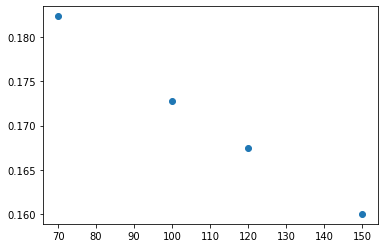

In [18]:
plt.scatter(no_of_features, rmse);

## Option 2: Implementing Funk SVD

No sigma matrix for Funk SVD matrix factorization, uses (polarity) value updating with gradient descent to find all reviewer-listing pairs. The listing and reviewer matrices (U and V) are randomly initialized. Works better than SVD for sparse matrices, but a lot more computationally expensive.

Could further add regularization weights to latent factors based on listing popularity and reviewer activeness: https://dl.acm.org/doi/10.1145/3285954

In [63]:
from math import sqrt
from IPython.display import clear_output
import timeit

def funkSVD(util_mat, latent_features=100, learning_rate=0.0001, iters=100, plot=True, use_prev_train=False, 
            prev_train_reviewer=None, prev_train_listing=None):  
    """ 
    Estimates the full matrix of polarities for user/item pairs using an implementation of Simon Funk's SVD
    
    :param util_mat: utility matrix with reviewer and listing axes
    :param latent_features: k, number of selected features to keep
    :param learning_rate: learning rate for gradient descent
    :param iters: number of iterations
    :plot: bool, whether to plot progress of iter vs cost fct (RMSE)
    :use_prev_train: bool, whether to initialize reviewer and listing matrices with a previous round of training 
    :prev_train_reviewer: previous round's reviewer matrix
    :prev_train_listing: previous round's listing matrix
    
    returns full estimated matrix, and U (reviewers) and V (listings) matrices
    """
    
    start = timeit.default_timer()
    util_mat = np.matrix(util_mat)
    n_reviewers = util_mat.shape[0]
    n_listings = util_mat.shape[1]
    
    # number of non-null polarity values we have (ie. known reviewer/listing polarity values)
    num_polarities = np.count_nonzero(~np.isnan(matrix))
    
    # if want to pick up training from last checkpoint
    if use_prev_train:
        reviewer_mat = prev_train_reviewer
        listing_mat = prev_train_listing
    else:
        # initialize the U and V matrices with random values in range -1 to 1 inclusive (polarity range)
        reviewer_mat = np.random.randint(-1, 2, size=(n_reviewers, latent_features)).astype(float)
        listing_mat = np.random.randint(-1, 2, size=(latent_features, n_listings)).astype(float)
    
    rmse_accum = 0
    rmse_list = []
    
    for iteration in range(iters):
        clear_output(wait=True)
        
        old_sse = rmse_accum
        rmse_accum = 0
        for i in range(n_reviewers):
            for j in range(n_listings):       
                # if polarity not nan
                if util_mat[i, j] > 0:                   
                    # compute the error between actual polarity and current (from init rand) polarity
                    diff = util_mat[i, j] - np.dot(reviewer_mat[i, :], listing_mat[:, j])
                    
                    # update RMSE
                    rmse_accum += sqrt(diff**2)
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        reviewer_mat[i, k] += learning_rate * (2*diff*listing_mat[k, j])
                        listing_mat[k, j] += learning_rate * (2*diff*reviewer_mat[i, k])
        
        rmse_list.append( rmse_accum / num_polarities )
        stop = timeit.default_timer()
        
        # print results for iteration
        print("Current iteration: %d, RMSE: %f" % (iteration+1, rmse_accum / num_polarities)),
        print("Current run time: %f minutes" % ((stop-start)/60))
        
        if plot:
            plt.figure()
            plt.scatter(np.arange(iteration+1), rmse_list)
            plt.plot(np.arange(iteration+1), rmse_list)
            plt.xlabel('iteration')
            plt.ylabel('RMSE');
            #plt.pause(1);
    
    # get full matrix as dot product of U and V
    full_mat = np.dot(reviewer_mat, listing_mat)
        
    return full_mat, reviewer_mat, listing_mat 

Current iteration: 100, RMSE: 0.156774
Current run time: 323.090000 minutes


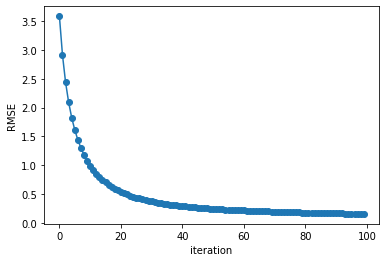

In [64]:
# matrix -> the utility matrix calculated in previous section

funk_full_mat, reviewer_mat, listing_mat = funkSVD(matrix, latent_features=50, learning_rate=0.001)

In [65]:
# save matrices as pkl files
import pickle

pickle.dump( funk_full_mat, open( "funk_full_mat.p", "wb" ) )
pickle.dump( reviewer_mat, open( "reviewer_mat.p", "wb" ) )
pickle.dump( listing_mat, open( "listing_mat.p", "wb" ) )

Or directly run an optimized and fast (Numba) python implementation, includes regularization, from https://github.com/gbolmier/funk-svd

In [ ]:
!pip install git+https://github.com/gbolmier/funk-svd

In [ ]:
#from funk_svd.dataset import fetch_ml_ratings

#df.sample(frac=0.8, random_state=7).head()

In [ ]:
from funk_svd import SVD

svd = SVD(learning_rate=0.001, regularization=0.005, n_epochs=100, n_factors=50, min_rating=-1, max_rating=1)
svd.fit(X=matrix, early_stopping=True, shuffle=False)

# Get top recommendations for a user

In [45]:
listing_id_array = df_rec['listing_id'].unique()

def get_recommendations(predMat, reviewer, N):
    """
    predMat: predicted matrix, svdout
    reviewer: selected reviewer_id
    N: top N recommendations
    
    return top N recommendations for specified user
    """
    u_index = users_index[reviewer]
    item_i = [items_index[listing_id_array[i]] for i in range(len(listing_id_array))]
    
    pred_user = [predMat[u_index, i_index] for i_index in item_i]
    
    d = {'listing_id': listing_id_array, 'predicted_polarity': pred_user}
    user_rec = pd.DataFrame(data=d)
    user_rec.sort_values(by=['predicted_polarity'], ascending=False, inplace=True)
    user_rec.reset_index(inplace=True, drop=True)
    
    return user_rec[:N]

In [38]:
# using mat from SVD method

user_rec = get_recommendations(svdout, df_rec['reviewer_id'][0], 10)
user_rec.style.bar(subset=['predicted_polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,predicted_polarity
0,14813006,0.995900
1,12603280,0.993300
2,14760739,0.993300
3,5584915,0.992850
4,8481291,0.992800
5,12699603,0.992800
6,13655073,0.992100
7,14220964,0.991700
8,7841193,0.991700
9,5719606,0.991700
